In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

file = uproot.open("testing_testfiles.root")
tree = file["TestTree"]

eventId = tree.array('eventId')
pfoId = tree.array('pfoId')
driftPos = tree.array('hitDriftPositionsW')
wirePos = tree.array('hitWirePositionsW')
pdg = tree.array('bestMCParticlePdgCode')
isTrack = tree.array('bestMCParticleIsTrack')
completeness = tree.array('completeness')
purity = tree.array('purity')
nHitsW = tree.array('nHitsInPfoW')
nHitsU = tree.array('nHitsInPfoU')
nHitsV = tree.array('nHitsInPfoV')
vertexdriftPos = tree.array('vertexDriftPosition')
vertexwirePos = tree.array('vertexWirePositionW')
hitEnergiesW = tree.array('hitEnergiesW')
particles = len(pfoId)

## Get identities of good pfos

In [2]:
comppureid = np.intersect1d(np.where(completeness > 0.89),np.where(purity > 0.89))
goodhits = []
for i in range(particles):
    if len(wirePos[i]) > 5:
        goodhits.append(i)
trueid = np.intersect1d(comppureid,goodhits)

# Tracks and showers

In [3]:
pfo_hits = np.array([ len(x) for x in wirePos > 5])

track_pfos = np.where((completeness > 0.9) & (purity > 0.89) & (pfo_hits > 5) & (isTrack == 1))

shower_pfos = np.where((completeness > 0.9) & (purity > 0.89) & (pfo_hits > 5) & (isTrack == 0))

# VARIABLE: Energies

In [5]:
hit_energies_sum = hitEnergiesW.sum()

In [6]:
hit_energies_sum_tracks = hit_energies_sum[track_pfos]
hit_energies_sum_showers = hit_energies_sum[shower_pfos]

## Regress the lines of best fit

In [7]:
#Find means in wire and drift for each pfo
wireav = wirePos[trueid].mean()
driftav = driftPos[trueid].mean()

#Find slope and intercept of lines of best fit
driftdiff = driftPos[trueid] - driftav
wirediff = wirePos[trueid] - wireav
driftwire = driftdiff*wirediff
driftsq = driftdiff**2
nume = driftwire.sum()
denom = driftsq.sum()
slope = nume/denom
intercept = wireav - slope*driftav
slopezero = np.where(slope==0.0)

## First and last points of each pfo

In [8]:
wirePos_sorted = []
driftPos_sorted = []

for i in range(len(wirePos)):
    wirePos_sorted.append(np.sort(wirePos[i]))
    
for i in range(len(driftPos)):
    driftPos_sorted.append(np.sort(driftPos[i]))

In [9]:
wirePosstart = []
wirePosend = []
driftPosstart = []
driftPosend = []
for i in trueid:
    wirePosstart.append(wirePos_sorted[i][0])
    wirePosend.append(wirePos_sorted[i][-1])
    driftPosstart.append(driftPos_sorted[i][0])
    driftPosend.append(driftPos_sorted[i][-1])

## Regress end points to line of best fit

In [10]:
xstart = []
xend = []
ystart = []
yend = []
for i in range(len(trueid)):
    if slope[i] != 0:
        slopeinv = -1.0/slope[i]
        startintercept = wirePosstart[i] - driftPosstart[i]*slopeinv
        endintercept = wirePosend[i] - driftPosend[i]*slopeinv
        xbegin = (startintercept - intercept[i])/(slope[i] - slopeinv)
        ybegin = slope[i]*xbegin + intercept[i]
        xfinish = (endintercept - intercept[i])/(slope[i]-slopeinv)
        yfinish = slope[i]*xfinish + intercept[i]
        xstart.append(xbegin)
        xend.append(xfinish)
        ystart.append(ybegin)
        yend.append(yfinish)
    else:
        xstart.append(driftPosstart[i])
        xend.append(driftPosend[i])
        ystart.append(wirePosstart[i])
        yend.append(wirePosend[i])
        

# Line lengths

In [11]:
linelength = []
for i in range(len(xstart)):
    xdiff = xend[i] - xstart[i]
    ydiff = yend[i] - ystart[i]
    lensq = xdiff**2 +ydiff**2
    length = np.sqrt(lensq)
    linelength.append(length)

In [12]:
track_pfo_energies = hitEnergiesW[track_pfos]
shower_pfo_energies = hitEnergiesW[shower_pfos]

In [13]:
# piplus_energies = hitEnergiesW[piplus]
# piminus_energies = hitEnergiesW[piminus]
# muon_energies = hitEnergiesW[muon]
# antimuon_energies = hitEnergiesW[antimuon]
# proton_energies = hitEnergiesW[proton]
# neutron_energies = hitEnergiesW[neutron]

# Regress all pfo points to line gosh this took 5ever

In [14]:
xpoints = []
ypoints = []
for i in range(len(trueid)):
    xcoord = []
    ycoord = []
    a = trueid[i]
    if slope[i] == 0.0:
        xcoord.append(driftPos[a])
        ycoord.append(wirePos[a])
    else:
        for j in range(len(wirePos[a])):
            slopeinv = -1.0/slope[i]
            pointintercept = wirePos[a][j] - driftPos[a][j]*slopeinv
            xpoint = (pointintercept - intercept[i])/(slope[i] - slopeinv)
            ypoint = slope[i]*xpoint + intercept[i]
            xcoord.append(xpoint)
            ycoord.append(ypoint)
    xpoints.append(xcoord)
    ypoints.append(ycoord)

# Normalise positions of regressed points for banter

In [15]:
pointsnorm = []
for i in range(len(trueid)):
    pointcoordnorm = []
    for j in range(len(xpoints[i])):
        xdifference = xpoints[i][j] - xpoints[i][0]
        lengf = xpoints[i][-1] - xpoints[i][0]
        normlength = xdifference/lengf
        pointcoordnorm.append(normlength)
    pointsnorm.append(pointcoordnorm)

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


# Order those regressed points along the line praise be to argsort

In [16]:
pointorder = []
for i in range(len(trueid)):
    lengthorder = np.argsort(pointsnorm[i])
    pointorder.append(lengthorder)

# Reorganise regressed points according to position, not gender or race

In [17]:
xpointsorder = []
ypointsorder = []
for i in range(len(trueid)):
    xpfosort = [xpoints for _,xpoints in sorted(zip(pointorder[i],xpoints[i]))]
    ypfosort = [ypoints for _,ypoints in sorted(zip(pointorder[i],ypoints[i]))]
    xpointsorder.append(xpfosort)
    ypointsorder.append(ypfosort)

# Find new lengths due to reordered points.

In [18]:
truelinelength = []
for i in range(len(xstart)):
    xdiff = xpointsorder[i][-1] - xpointsorder[i][0]
    ydiff = ypointsorder[i][-1] - ypointsorder[i][0]
    lensq = xdiff**2 + ydiff**2
    length = np.sqrt(lensq)
    truelinelength.append(length)

# Find new normalised point positions 

In [19]:
truepointsnorm = []
for i in range(len(trueid)):
    truepointcoordnorm = []
    a = trueid[i]
    for j in range(len(xpointsorder[i])):
        xdifference = xpointsorder[i][j] - xpointsorder[i][0]
        ydifference = ypointsorder[i][j] - ypointsorder[i][0]
        lengthsq = xdifference**2 + ydifference**2
        truelen = np.sqrt(lengthsq)
        normlength = truelen/truelinelength[i]
        truepointcoordnorm.append(normlength)
    truepointsnorm.append(truepointcoordnorm)

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Indices of hits that are > 0.8 along the line

In [20]:
truepoints_tracks = []
truepoints_showers = []

for i in range(len(truepointsnorm)):
    a = trueid[i]
    if a in track_pfos[0]:
        truepoints_tracks.append(truepointsnorm[i])
    elif a in shower_pfos[0]:
        truepoints_showers.append(truepointsnorm[i])

In [21]:
truepointsTracks=np.array([np.array(i) for i in truepoints_tracks])
truepointsShowers=np.array([np.array(i) for i in truepoints_showers])

In [22]:
end_indices_tracks = []

for i in range(len(track_pfos[0])):
    end_indices_tracks.append(np.array(np.where(truepointsTracks[i] > 0.8)))

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [23]:
#Track energies in final 20%

end_track_energies = []

for i in range(len(track_pfo_energies)):
    end_track_energies.append(np.array(track_pfo_energies[i][end_indices_tracks[i]]))

In [24]:
end_track_energies_sum = []

for i in range(len(track_pfos[0])):
    end_track_energies_sum.append(end_track_energies[i].sum())

In [25]:
#Fraction of the total PFO energy contained in hits in the final 20%

energy_frac_tracks = end_track_energies_sum / hit_energies_sum_tracks

In [26]:
end_indices_showers = []

for i in range(len(shower_pfos[0])):
    end_indices_showers.append(np.array(np.where(truepointsShowers[i] > 0.8)))

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [27]:
end_shower_energies = []

for i in range(len(shower_pfo_energies)):
    end_shower_energies.append(shower_pfo_energies[i][end_indices_showers[i]])

In [28]:
end_shower_energies_sum = []

for i in range(len(shower_pfos[0])):
    end_shower_energies_sum.append(end_shower_energies[i].sum())

In [29]:
energy_frac_showers = end_shower_energies_sum / hit_energies_sum_showers

In [30]:
weight_tracks = np.ones_like(energy_frac_tracks) / len(energy_frac_tracks)
weight_showers = np.ones_like(energy_frac_showers) / len(energy_frac_showers)

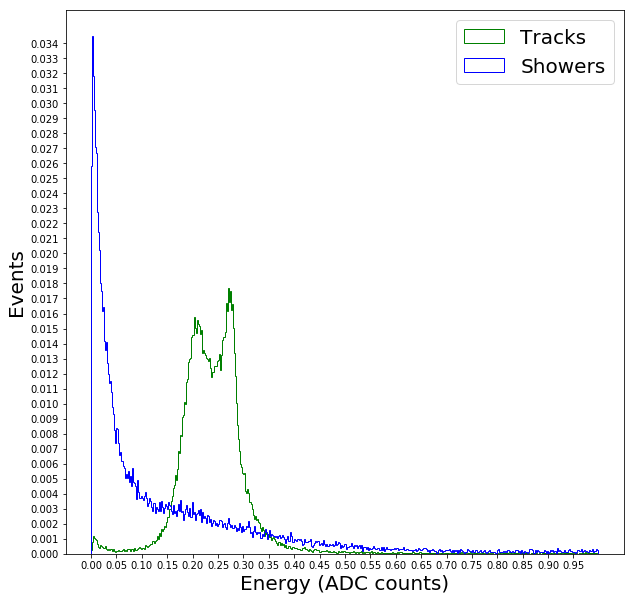

In [31]:
fig = plt.figure(1, figsize=(10, 10))
energies_tracks_hist = plt.hist(energy_frac_tracks, 500, weights = weight_tracks, color = 'g', histtype = u'step', label = 'Tracks')
energies_showers_hist = plt.hist(energy_frac_showers, 500, weights = weight_showers, color = 'b', histtype = u'step', label = 'Showers')
#plt.title('Energies: Tracks and Showers', fontsize = 20)
plt.xlabel('Energy (ADC counts)', fontsize=20)
plt.ylabel('Events', fontsize=20)

plt.xticks(np.arange(min(energy_frac_tracks), max(energy_frac_tracks), 0.05))

plt.yticks(np.arange(0, 0.035, 0.001))

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

plt.legend(prop={"size":20})
        
plt.show()

# VARIABLE: Angles

# Calculate means

In [37]:
drift_pos_av = driftPos.mean()
wire_pos_av = wirePos.mean()

# Calculate gradient

In [38]:
drift_comp = driftPos - drift_pos_av
wire_comp = wirePos - wire_pos_av
drift_comp_sq = drift_comp ** 2
numerator = (drift_comp * wire_comp).sum()
denominator = (drift_comp_sq).sum()
m = numerator / denominator
c = wire_pos_av - m * drift_pos_av

C:\Users\r.xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [39]:
select_wirePos_tracks = wirePos[track_pfos]

select_driftPos_tracks = driftPos[track_pfos]

select_wirePos_showers = wirePos[shower_pfos]

select_driftPos_showers = driftPos[shower_pfos]

vertexdriftPos_tracks = vertexdriftPos[track_pfos]

vertexwirePos_tracks = vertexwirePos[track_pfos]

vertexdriftPos_showers = vertexdriftPos[shower_pfos]

vertexwirePos_showers = vertexwirePos[shower_pfos]

m_tracks = m[track_pfos]

c_tracks = c[track_pfos]

m_showers = m[shower_pfos]

c_showers = c[shower_pfos]

# Plot tracks

In [40]:
y_values_tracks = []
m_values_tracks = []
c_values_tracks = []

for i in range(len(track_pfos[0])):
        
        y = m_tracks[i]*select_driftPos_tracks[i] + c_tracks[i]
#         fig = plt.figure(figsize = (10, 15))
#         plt.scatter(select_driftPos_tracks[i], select_wirePos_tracks[i], color = 'b', s = 1)
#         plt.plot(select_driftPos_tracks[i], y, color = 'r', linewidth = 3) 
#         plt.scatter(x_origin_tracks[i], y_origin_tracks[i], color = 'g', s = 150)
#         plt.scatter(select_driftPos_tracks[1][100], select_wirePos_tracks[1][100], color = 'g', s = 150, marker = 'x')

        
        y_values_tracks.append(y)

        m_values_tracks.append(m_tracks[i])

        c_values_tracks.append(c_tracks[i])

# Plot showers

In [41]:
y_values_showers = []
m_values_showers = []
c_values_showers = []

for i in range(len(shower_pfos[0])):
        
        y = m_showers[i]*select_driftPos_showers[i] + c_showers[i]
#         fig = plt.figure(figsize = (10, 11))
#         plt.scatter(select_driftPos_showers[i], select_wirePos_showers[i], color = 'b', s = 1)
#         plt.plot(select_driftPos_showers[i], y, color = 'r', linewidth = 2) 
#         plt.scatter(x_origin_showers[i], y_origin_showers[i], color = 'gold', s = 150)
#         plt.scatter(vertexdriftPos_showers[i], vertexwirePos_showers[i], color = 'k', s = 150, marker = 'x')
#         plt.xlabel('Drift Position', fontsize=20)
#         plt.ylabel('Wire Position (cm)', fontsize=20)
#         plt.xticks(fontsize=20)
#         plt.yticks(fontsize=20)
    
        y_values_showers.append(y)

        m_values_showers.append(m_showers[i])

        c_values_showers.append(c_showers[i])

# Tracks: Get first x and y values for each PFO regression line

In [42]:
first_y_tracks = []
first_x_tracks = []
last_x_tracks = []
last_y_tracks = []

for i in range(len(track_pfos[0])):
    
    origin_x = select_driftPos_tracks[i][0]
    
    origin_y = (m_values_tracks[i] * select_driftPos_tracks[i][0]) + c_values_tracks[i]
    
    end_x = select_driftPos_tracks[i][-1]
    
    end_y = (m_values_tracks[i] * select_driftPos_tracks[i][-1]) + c_values_tracks[i]
    
    first_y_tracks.append(origin_y)
    
    first_x_tracks.append(origin_x)
    
    last_y_tracks.append(end_y)
    
    last_x_tracks.append(end_x)

# Tracks: Regression line vector

In [43]:
d_zero_tracks = ((vertexwirePos_tracks - first_y_tracks) ** 2) + ((vertexdriftPos_tracks - first_x_tracks) ** 2)
d_end_tracks = ((vertexwirePos_tracks - last_y_tracks) ** 2) + ((vertexdriftPos_tracks - last_x_tracks) ** 2)

In [44]:
x_sinc_tracks = []
y_sinc_tracks = []

x_origin_tracks = []
y_origin_tracks = []

for i in range(len(track_pfos[0])):
    
    x_origin, y_origin = (first_x_tracks[i], first_y_tracks[i]) if d_zero_tracks[i] < d_end_tracks[i] else (last_x_tracks[i], last_y_tracks[i])
    
    x_origin_tracks.append(x_origin)
    
    y_origin_tracks.append(y_origin)
    
    x_sinc, y_sinc = (first_x_tracks[i], first_y_tracks[i]) if d_zero_tracks[i] >= d_end_tracks[i] else (last_x_tracks[i], last_y_tracks[i])
    
    x_sinc_tracks.append(x_sinc)
    
    y_sinc_tracks.append(y_sinc)

In [45]:
x_line_vector_tracks = np.array(x_sinc_tracks) - np.array(x_origin_tracks)
y_line_vector_tracks = np.array(y_sinc_tracks) - np.array(y_origin_tracks)

In [46]:
mag_line_tracks = np.sqrt((x_line_vector_tracks ** 2) + (y_line_vector_tracks ** 2))

# Tracks: Hits vector

In [47]:
x_hit_vector_tracks = select_driftPos_tracks - x_origin_tracks
y_hit_vector_tracks = select_wirePos_tracks - y_origin_tracks

In [48]:
mag_hit_tracks = np.sqrt((x_hit_vector_tracks ** 2) + (y_hit_vector_tracks ** 2))

# Tracks: Calculate angle

In [49]:
theta_num_tracks = (x_line_vector_tracks * x_hit_vector_tracks) + (y_line_vector_tracks * y_hit_vector_tracks)
theta_denom_tracks = mag_line_tracks * mag_hit_tracks
theta_tracks = theta_num_tracks / theta_denom_tracks

C:\Users\r.xavier\Anaconda3\lib\site-packages\awkward\array\jagged.py:1043: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
angle_tracks = np.degrees(np.arccos(theta_tracks))
av_theta_tracks = (angle_tracks.mean())

C:\Users\r.xavier\Anaconda3\lib\site-packages\awkward\array\jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Showers: Get first x and y values for each PFO regression line


In [51]:
first_y_showers = []
first_x_showers = []
last_x_showers = []
last_y_showers = []

for i in range(len(shower_pfos[0])):
    
    origin_x = select_driftPos_showers[i][0]
    
    origin_y = (m_values_showers[i] * select_driftPos_showers[i][0]) + c_values_showers[i]
    
    end_x = select_driftPos_showers[i][-1]
    
    end_y = (m_values_showers[i] * select_driftPos_showers[i][-1]) + c_values_showers[i]
    
    first_y_showers.append(origin_y)
    
    first_x_showers.append(origin_x)
    
    last_y_showers.append(end_y)
    
    last_x_showers.append(end_x)

# Showers: Regression line vector

In [52]:
d_zero_showers = ((vertexwirePos_showers - first_y_showers) ** 2) + ((vertexdriftPos_showers - first_x_showers) ** 2)
d_end_showers = ((vertexwirePos_showers - last_y_showers) ** 2) + ((vertexdriftPos_showers - last_x_showers) ** 2)

In [53]:
x_sinc_showers = []
y_sinc_showers = []

x_origin_showers = []
y_origin_showers = []

for i in range(len(shower_pfos[0])):
    
    x_origin, y_origin = (first_x_showers[i], first_y_showers[i]) if d_zero_showers[i] < d_end_showers[i] else (last_x_showers[i], last_y_showers[i])
    
    x_origin_showers.append(x_origin)
    
    y_origin_showers.append(y_origin)
    
    x_sinc, y_sinc = (first_x_showers[i], first_y_showers[i]) if d_zero_showers[i] >= d_end_showers[i] else (last_x_showers[i], last_y_showers[i])
    
    x_sinc_showers.append(x_sinc)
    
    y_sinc_showers.append(y_sinc)
    

In [54]:
x_line_vector_showers = np.array(x_sinc_showers) - np.array(x_origin_showers)
y_line_vector_showers = np.array(y_sinc_showers) - np.array(y_origin_showers)

In [55]:
mag_line_showers = np.sqrt((x_line_vector_showers ** 2) + ((y_line_vector_showers) ** 2))

# Showers: Hits vector

In [56]:
x_hit_vector_showers =  select_driftPos_showers - x_origin_showers 
y_hit_vector_showers = select_wirePos_showers - y_origin_showers

In [57]:
mag_hit_showers = np.sqrt((x_hit_vector_showers ** 2) + ((y_hit_vector_showers) ** 2))

# Showers: Calculate angle

In [58]:
theta_num_showers = (x_line_vector_showers * x_hit_vector_showers) + (y_line_vector_showers * y_hit_vector_showers)
theta_denom_showers = mag_line_showers * mag_hit_showers
theta_showers = theta_num_showers / theta_denom_showers

In [59]:
angle_showers = np.degrees(np.arccos(theta_showers))
av_theta_showers = (angle_showers.mean())

In [62]:
weight_tracks = np.ones_like(av_theta_tracks) / len(av_theta_tracks)
weight_showers = np.ones_like(av_theta_showers) / len(av_theta_showers)

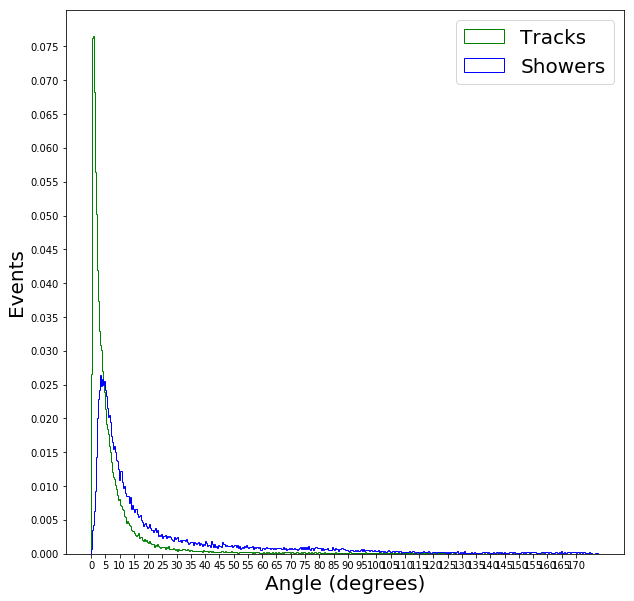

In [63]:
fig = plt.figure(1, figsize=(10, 10))
angles_tracks_hist = plt.hist(av_theta_tracks, 500, weights = weight_tracks, color = 'g', histtype = u'step', label = 'Tracks')
angles_showers_hist = plt.hist(av_theta_showers, 500, weights = weight_showers, color = 'b', histtype = u'step', label = 'Showers')
#plt.title('Angles: Tracks and Showers', fontsize = 20)
plt.xlabel('Angle (degrees)', fontsize=20)
plt.ylabel('Events', fontsize=20)
#plt.xticks(fontsize=20)

plt.xticks(np.arange(min(av_theta_tracks), max(av_theta_tracks), 5.0))

plt.yticks(np.arange(0, 0.08, 0.005))

#plt.yticks(fontsize=20)



plt.legend(prop={"size":20})
        
plt.show()


# PROBABILITY: Energies

In [93]:
all_energies = list(energy_frac_tracks) + list(energy_frac_showers)

In [94]:
#For some reason np.shape(x) is always 1 greater than np.shape(y) so just removed last x value
xp_energies_tracks = energies_tracks_hist[1][:-1]
fp_energies_tracks = energies_tracks_hist[0]
x_energies = all_energies

In [95]:
energies_tracks_probs = np.interp(x_energies, xp_energies_tracks, fp_energies_tracks)

In [ ]:
xp_energies_showers = energies_showers_hist[1][:-1]
fp_energies_showers = energies_showers_hist[0]
x_energies = all_energies

In [97]:
energies_showers_probs = np.interp(x_energies, xp_energies_showers, fp_energies_showers)

# PROBABILITY: Angles

In [64]:
all_angles = list(av_theta_tracks) + list(av_theta_showers)

In [89]:
xp_angles_tracks = angles_tracks_hist[1][:-1]
fp_angles_tracks = angles_tracks_hist[0]
x_angles = all_angles

In [90]:
angles_tracks_probs = np.interp(x_angles, xp_angles_tracks, fp_angles_tracks)

In [91]:
xp_showers_tracks = angles_showers_hist[1][:-1]
fp_showers_tracks = angles_showers_hist[0]
x_angles = all_angles

In [92]:
angles_showers_probs = np.interp(x_angles, xp_showers_tracks, fp_showers_tracks)

# PROBABILITY: ROB TAKE THE STAGE

# PRIOR PROBABILITIES

In [111]:
prior_probability_tracks = len(track_pfos[0])/(len(track_pfos[0]) + len(shower_pfos[0]))

In [112]:
prior_probability_showers = len(shower_pfos[0])/(len(track_pfos[0]) + len(shower_pfos[0]))

# THE BIG P's

In [103]:
p_track = angles_tracks_probs * energies_tracks_probs * prior_probability_tracks

In [113]:
p_shower = angles_showers_probs * energies_showers_probs * prior_probability_showers

# LIKELIHOOD (OF THESE RESULTS BEING GOOD????)

In [114]:
l = p_track/(p_track+p_shower)

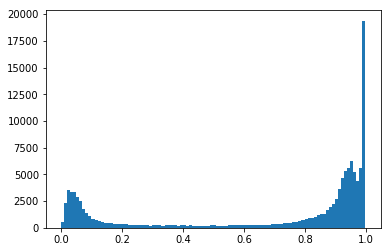

In [117]:
plt.hist(l, 100)
plt.show()